#### Montar pasta do Google Drive ####

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Imports e pip ####

In [319]:
!pip install transformers
!pip install imbalanced-learn
!pip install pandas
!pip install nltk
!pip install mlxtend

In [469]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import metrics
from matplotlib import pyplot
from scipy.stats import loguniform
from IPython.display import display
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re

In [426]:
# termos muito frequentes que não tem relevância nos dados. São palavras que possuem apenas significado sintático dentro da sentença, porém não trazem informações relevantes sobre o seu sentido.
nltk.download('stopwords')
# RSLP Stemmer (Removedor de Sufixos da Lingua Portuguesa)
nltk.download('rslp')
# punkt é um tokenizer 
nltk.download('punkt')
# dicionário de léxicos (conjunto de vocabulários de determinado idioma) e hierarquia de termos
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Carregar os dados nos dataframes ####

In [427]:
df_teste = pd.read_csv('../dataset/teste.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_treino = pd.read_csv('../dataset/treino.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_validacao = pd.read_csv('../dataset/validacao.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df = pd.concat([df_treino, df_teste, df_validacao])

#### Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)

In [428]:
df.count()

texto     20004
emocao    19995
dtype: int64

In [429]:
df.head(3)

,texto,emocao
0,não me senti humilhado,tristeza
1,posso passar de me sentindo tão sem esperança ...,tristeza
2,estou pegando um minuto para postar me sinto g...,raiva


<AxesSubplot:>

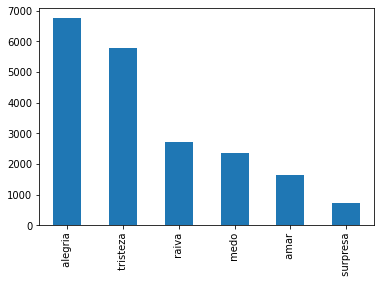

In [430]:
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

#### Feature Engineer:

* Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)
* Remover valores nulos/NAN
* Remover linhas duplicadas

In [431]:
df.isna().sum()

texto     0
emocao    9
dtype: int64

In [432]:
df = df.dropna()

In [433]:
df.isna().sum()

texto     0
emocao    0
dtype: int64

In [434]:
df.count()

texto     19995
emocao    19995
dtype: int64

In [435]:
df = df.drop_duplicates(['texto'])

In [436]:
df.count()

texto     19918
emocao    19918
dtype: int64

#### Defini funções para pre processamento

In [437]:
pontuacao = list(string.punctuation)

In [438]:
def exclui_palavras_irrelevantes(texto):
    stops = set(stopwords.words('portuguese') + pontuacao)
    palavras = [i for i in texto.split() if not i in stops]
    return (" ".join(palavras))

In [439]:
def exclui_radicais(texto):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in texto.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [440]:
def exclui_pontuacao(texto):
    palavras = [i for i in texto if not i in pontuacao]
    return ("".join(palavras))

In [441]:
def lemmatization(instancia):
    wordnet_lemmatizer = WordNetLemmatizer()
    palavras = []
    for w in instancia.split():
        palavras.append(wordnet_lemmatizer.lemmatize(w))
    return (" ".join(palavras))


#### Aplica as funções de pre-processamento nos dados e split Train / Test dataset

* Avaliar o uso do Stemming (remove o radical das palavras (Ex. altera frequentemente para frenquent, imediatamente para imediat), isso pode trazer um problema pois ele pode gerar palavras que não existem no idioma.
* Avaliar o uso do Lemmatization (Ex. uma forma de Stemming que mantém a palavra com significado real (Ex. altera frequentemente para frenquente, imediatamente para imediato). O problema dessa abordagem, é que o Lemmatizer do NLTK utiliza o Dicionário da WordNet que não é específico para o Portugues

In [442]:
def pre_processing(texto, show_results=False):
    stemmer = exclui_radicais(texto)
    pont = exclui_pontuacao(stemmer)
    stops = exclui_palavras_irrelevantes(pont)
    lemma = lemmatization(stops)
    # palavras = [stemmer.stem(i) for i in instancia.split() if not i in stops]
    if(show_results):
        print('Original text: {}'.format(texto))
        print('Stemmer aplicado: {}'.format(stemmer))
        print('Exclusao de pontuação aplicado: {}'.format(pont))
        print('Exclusao de stopwords aplicado: {}'.format(stops))
    return ("".join(lemma))

In [443]:
# Analise sobre possível desbalanceamento de classes
df['emocao'].value_counts()

 alegria     6735
 tristeza    5779
 raiva       2698
 medo        2365
 amar        1629
 surpresa     712
Name: emocao, dtype: int64

<AxesSubplot:>

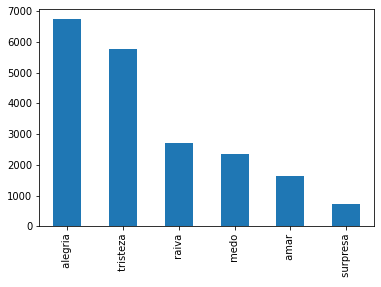

In [444]:
# Analise sobre possível desbalanceamento de classes
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

In [445]:
# aplicando os processos de tratamento nos texto (retirada de pontuação, stopwords, stemmer e lemmatization)
X = [pre_processing(i) for i in df['texto']]

In [446]:
labelencoder = LabelEncoder()
df['emocao_encoded'] = labelencoder.fit_transform(df['emocao'])

X_train, X_test, y_train, y_test = train_test_split(pd.Series(X), df['emocao_encoded'], random_state=41, test_size=0.2, stratify=df['emocao_encoded'])

# Com o uso do Undersampler a performce do modelo piora, muito provavelmente devido a grande diminuição de dados
undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(pd.DataFrame(X), df['emocao_encoded'])
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under.squeeze(), y_under, random_state=41, test_size=0.2, stratify=y_under)

In [447]:
type(df['emocao_encoded'])
# X_test

pandas.core.series.Series

In [448]:
df[['emocao','emocao_encoded']].drop_duplicates()

,emocao,emocao_encoded
0,tristeza,5
2,raiva,3
3,amar,1
6,surpresa,4
7,medo,2
8,alegria,0


<AxesSubplot:>

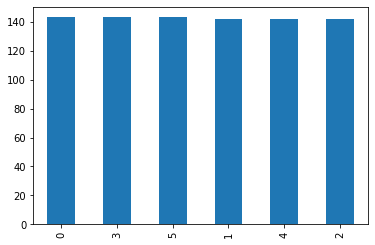

In [449]:
# analisando o resultado da aplicação de undersampler nas classes para ficarem próximas ao da classe minoritária
%matplotlib inline
y_test_under.value_counts().plot(kind='bar')

#### Tokenização - Importante. Por não se tratar de uma análise de dados recuperados da internet, onde existe um linguajar específico onde é usado emoticons, hashtag, emojis e etc, para essa análise não precisamos utilizar o Tokenizer do Tweeter para tratar esse tipo de linguajar. Podemos usar o Tokenizer de palavras normais e entender que o espaço é o suficiente para separar as palavras sem afetar o sentido do textos

#### Frases e Predições de teste

In [450]:
testes = ['eu posso ter para um deleite ou se estou me sentindo festivo',
          'estou me sentindo muito triste e com pena de mim mesma, mas logo vou me livrar disso',
          'estou apenas me sentindo mal-humorada e azul ',
          'só sei que, para começar, vou me sentir tímido com isso',
          'eu também adorei que você pudesse realmente sentir o desespero nessas sequências e eu gostei especialmente da emoção entre cavaleiro e escudeiro, já que eles estão juntos de maneira semelhante a batman e robin há muito tempo',
          'estou me sentindo um pouco atordoada com a quantidade de itens que não uso mais para decoração']

predicao_correta = ['alegria', 'tristeza', 'raiva', 'medo', 'amar', 'surpresa']

In [451]:
testes = [pre_processing(i) for i in testes]

In [452]:
# Transforma os dados de teste em vetores de palavras.
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
texto_teste_vetorizado = tfidf_vectorizer.transform(testes)

#### Vetorização dos textos

*   CountVectorizer: [BagOfWords Model] - É uma representação numérica de uma fração do texto que facilita a classificação, dessa forma o algoritmo conta a frequnência com que a palavra aparece no texto e cria um dicionário disso. Isso é chamado de Tokenization in NLP (Natural Language Processing). O CountVectorizer realiza esse processo
*   TfidfVectorizer: Transforma texto em vetores de recursos que podem ser usados ​​como entrada para o estimador



In [453]:
def get_vectorize_instance(vectorize_name):
    if(vectorize_name == 'CountVectorizer'):
        return CountVectorizer(analyzer="word")
    elif(vectorize_name == 'TfidfVectorizer'):
        return TfidfVectorizer()
    else:
        raise Exception("Vectorizer not found!")

In [454]:
def vectorize_dataframe(vectorizer, X_train, X_test):
    if(type(vectorizer) is CountVectorizer):
        train_data = vectorizer.fit_transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    elif (type(vectorizer) is TfidfVectorizer):
        vectorizer.fit(X_train)
        train_data = vectorizer.transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    else:
        raise Exception("Vectorizer type incorrect!")

In [455]:
def train_model(modelo, X_train, y_train):
    return modelo.fit(X_train, y_train)

In [456]:
def predict_model(modelo, X_test):
    return modelo.predict(X_test)

In [457]:
def score_model(modelo, X_test, y_test):
    return modelo.score(X_test, y_test)

In [458]:
def plot_predict_right(X_test, predictions, right_predictions, num_rows=5):
    pred = pd.DataFrame({'predição modelo': predictions, 'predição correta': right_predictions})
    display(pred[:num_rows])

In [459]:
def plot_classification_report(y_test, y_pred):
    print(metrics.classification_report(y_test, y_pred))

In [460]:
def plot_confusion_matrix_graph(y_test, y_pred):
    cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)
    fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=False, show_normed=True, figsize=(10, 10))
    plt.show()

In [615]:
def evaluates_score_model(modelo, vectorizer, X_train, X_test, y_train, y_test):
    print('#######################################################################################################################################')
    print('##### Avaliando Modelo {} / Vectorizer {} #####'.format(modelo, vectorizer))
    train_vectorized, test_vectorized = vectorize_dataframe(vectorizer, X_train, X_test)
    model = train_model(modelo, train_vectorized, y_train)
    y_pred = predict_model(modelo, test_vectorized)
    print('Accuracy do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.accuracy_score(y_test, y_pred))))
    print('Precision do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.precision_score(y_test, y_pred, average='macro'))))
    print('Recall do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.recall_score(y_test, y_pred, average='macro'))))
    print('F1-Score do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.f1_score(y_test, y_pred, average='macro'))))
    plot_predict_right(X_test, y_pred, y_test)
    plot_classification_report(y_test, y_pred)
#     plot_confusion_matrix_graph(y_test, y_pred)
    print('\n')
    return modelo, vectorizer, y_pred

In [491]:
classifiers = {
        'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'MultinomialNB': MultinomialNB(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
        'SVC': SVC(kernel='linear'),
        'SGDClassifier': SGDClassifier(loss="log", penalty="l2"),
        'DecisionTreeClassifier': DecisionTreeClassifier(criterion="gini"),
        'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
        'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=150),
    }

In [492]:
def get_model_instace(model):
    return classifiers.get(model) 

In [490]:
list_models = [get_model_instace('LogisticRegression')
                ,get_model_instace('MultinomialNB')
                ,get_model_instace('RandomForestClassifier')
                ,get_model_instace('SVC')
                ,get_model_instace('SGDClassifier')
                ,get_model_instace('DecisionTreeClassifier')
                ,get_model_instace('KNeighborsClassifier')
                ,get_model_instace('GradientBoostingClassifier')]

list_vectors_instance = [get_vectorize_instance('CountVectorizer'), get_vectorize_instance('TfidfVectorizer')]

In [614]:
def evaluates_all_models(list_models, list_vectors_instance):
    modelos = []
    vectorizers = []
    y_predictions = []
    for m in list_models:
        for vec in list_vectors_instance:
            modelo, vec, y_pred = evaluates_score_model(m, vec, X_train_under, X_test_under, y_train_under, y_test_under)
            modelos.append(modelo), y_predictions.append(y_pred), vectorizers.append(vec)
#             d[modelo] = y_pred
    print('##### Fim avaliação #####')
    return modelos, vectorizers, y_predictions

In [666]:
def plot_all_confusion_matrix(modelos, vectorizers, y_test, y_predictions):
    '''
    Método responsável por plotar a matriz de confusão dos modelos passados via parametro
    '''
    cols = 4
    rows = 4 
    
    f, axes = plt.subplots(rows, cols, figsize=(60, 50), sharey='row')

    idx_col = 0
    idx_row = 0

    for m, v, y in zip(modelos, vectorizers, y_predictions):

        cm = confusion_matrix(y_test, y, labels = m.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = m.classes_)
        
        if(idx_col == cols):
            idx_row = idx_row + 1
            idx_col = 0
            disp.plot(ax=axes[idx_row, idx_col], xticks_rotation=5)
            idx_col = idx_col + 1
        else:
            disp.plot(ax=axes[idx_row, idx_col], xticks_rotation=5)
            idx_col = idx_col + 1

        disp.ax_.set_title('{} - {}'.format(str(type(m).__name__)[0:5], str(v)[0:5]))
        disp.im_.colorbar.remove()
    #     disp.ax_.set_xlabel('')
    #     if i!=0:
    #         disp.ax_.set_ylabel('')

    # f.text(0.4, 0.1, 'Predicted label', ha='left')
#     plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.subplots_adjust(wspace=1.0, hspace=.50)

    # f.colorbar(disp.im_, ax=axes)
    # f.colorbar().remove()
    plt.show()

In [618]:
# executa o método que fará a avaliação dos modelos
modelos, vectorizers, y_predictions = evaluates_all_models(list_models, list_vectors_instance)

#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer CountVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.710
Precision do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.714
Recall do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.710
F1-Score do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.711


C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,predição modelo,predição correta
1172,1,1
3407,4,4
1552,5,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.58      0.59      0.59       143
           1       0.70      0.69      0.69       142
           2       0.80      0.72      0.76       142
           3       0.75      0.72      0.73       143
           4       0.86      0.89      0.88       142
           5       0.59      0.66      0.62       143

    accuracy                           0.71       855
   macro avg       0.71      0.71      0.71       855
weighted avg       0.71      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer TfidfVectorizer() é de 0.699
Precision do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer TfidfVectorizer() é de 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.57      0.57      0.57       143
           1       0.63      0.70      0.66       142
           2       0.76      0.69      0.72       142
           3       0.79      0.72      0.75       143
           4       0.85      0.88      0.87       142
           5       0.62      0.64      0.63       143

    accuracy                           0.70       855
   macro avg       0.70      0.70      0.70       855
weighted avg       0.70      0.70      0.70       855



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer CountVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.654
Precision do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.651
Recall do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.654
F1-Scor

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,4,2
334,1,0
3321,1,4


              precision    recall  f1-score   support

           0       0.60      0.56      0.58       143
           1       0.64      0.64      0.64       142
           2       0.63      0.66      0.64       142
           3       0.67      0.66      0.67       143
           4       0.74      0.83      0.78       142
           5       0.63      0.57      0.60       143

    accuracy                           0.65       855
   macro avg       0.65      0.65      0.65       855
weighted avg       0.65      0.65      0.65       855



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.687
Precision do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.686
Recall do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.687
F1-Scor

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,4,2
334,1,0
3321,1,4


              precision    recall  f1-score   support

           0       0.60      0.57      0.59       143
           1       0.66      0.69      0.68       142
           2       0.67      0.68      0.68       142
           3       0.77      0.69      0.73       143
           4       0.73      0.87      0.79       142
           5       0.69      0.61      0.65       143

    accuracy                           0.69       855
   macro avg       0.69      0.69      0.68       855
weighted avg       0.69      0.69      0.68       855



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.703
Precision do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.711
Recall do Modelo RandomForestClassifier() com Vectorizer 

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,0,2
334,4,0
3321,4,4


              precision    recall  f1-score   support

           0       0.57      0.57      0.57       143
           1       0.66      0.70      0.68       142
           2       0.85      0.73      0.78       142
           3       0.80      0.71      0.75       143
           4       0.84      0.88      0.86       142
           5       0.55      0.62      0.58       143

    accuracy                           0.70       855
   macro avg       0.71      0.70      0.71       855
weighted avg       0.71      0.70      0.71       855



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.677
Precision do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.688
Recall do Modelo RandomForestClassifier() com Vectorizer 

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,4,0
3321,4,4


              precision    recall  f1-score   support

           0       0.52      0.55      0.54       143
           1       0.63      0.70      0.66       142
           2       0.83      0.66      0.74       142
           3       0.77      0.69      0.73       143
           4       0.83      0.88      0.86       142
           5       0.53      0.58      0.55       143

    accuracy                           0.68       855
   macro avg       0.69      0.68      0.68       855
weighted avg       0.69      0.68      0.68       855



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.677
Precision do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.682
Recall do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer(

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.53      0.63      0.58       143
           1       0.61      0.63      0.62       142
           2       0.77      0.67      0.71       142
           3       0.72      0.66      0.69       143
           4       0.84      0.89      0.86       142
           5       0.62      0.59      0.60       143

    accuracy                           0.68       855
   macro avg       0.68      0.68      0.68       855
weighted avg       0.68      0.68      0.68       855



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.703
Precision do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.712
Recall do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer(

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.55      0.66      0.60       143
           1       0.65      0.66      0.66       142
           2       0.79      0.70      0.75       142
           3       0.77      0.67      0.72       143
           4       0.85      0.85      0.85       142
           5       0.66      0.67      0.67       143

    accuracy                           0.70       855
   macro avg       0.71      0.70      0.71       855
weighted avg       0.71      0.70      0.71       855



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.694
Precision do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.695
Recall do Modelo SGDClassifier(loss='log') com Vectori

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.56      0.57      0.57       143
           1       0.62      0.70      0.66       142
           2       0.77      0.70      0.73       142
           3       0.74      0.73      0.74       143
           4       0.85      0.87      0.86       142
           5       0.63      0.58      0.60       143

    accuracy                           0.69       855
   macro avg       0.70      0.69      0.69       855
weighted avg       0.70      0.69      0.69       855



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.713
Precision do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.715
Recall do Modelo SGDClassifier(loss='log') com Vectori

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.59      0.62      0.60       143
           1       0.65      0.70      0.67       142
           2       0.75      0.72      0.73       142
           3       0.78      0.73      0.75       143
           4       0.86      0.89      0.88       142
           5       0.67      0.62      0.64       143

    accuracy                           0.71       855
   macro avg       0.72      0.71      0.71       855
weighted avg       0.72      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.650
Precision do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.655
Recall do Modelo DecisionTreeClassifier() com Vectorizer 

,predição modelo,predição correta
1172,0,1
3407,4,4
1552,2,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.60      0.55      0.57       143
           1       0.61      0.67      0.64       142
           2       0.76      0.65      0.70       142
           3       0.67      0.70      0.68       143
           4       0.82      0.83      0.83       142
           5       0.47      0.50      0.48       143

    accuracy                           0.65       855
   macro avg       0.65      0.65      0.65       855
weighted avg       0.65      0.65      0.65       855



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.596
Precision do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.608
Recall do Modelo DecisionTreeClassifier() com Vectorizer 

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.42      0.38      0.40       143
           1       0.64      0.63      0.64       142
           2       0.74      0.61      0.66       142
           3       0.62      0.69      0.65       143
           4       0.84      0.80      0.82       142
           5       0.39      0.48      0.43       143

    accuracy                           0.60       855
   macro avg       0.61      0.60      0.60       855
weighted avg       0.61      0.60      0.60       855



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.344
Precision do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.350
Recall do Modelo KNeighborsClassifier() com Vectorizer CountVec

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.32      0.39      0.35       143
           1       0.28      0.28      0.28       142
           2       0.31      0.39      0.35       142
           3       0.40      0.44      0.42       143
           4       0.47      0.33      0.39       142
           5       0.32      0.22      0.26       143

    accuracy                           0.34       855
   macro avg       0.35      0.34      0.34       855
weighted avg       0.35      0.34      0.34       855



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.582
Precision do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.593
Recall do Modelo KNeighborsClassifier() com Vectorizer TfidfVec

,predição modelo,predição correta
1172,4,1
3407,4,4
1552,2,2
334,0,0
3321,5,4


              precision    recall  f1-score   support

           0       0.48      0.65      0.55       143
           1       0.54      0.49      0.52       142
           2       0.59      0.64      0.61       142
           3       0.69      0.66      0.68       143
           4       0.59      0.61      0.60       142
           5       0.66      0.44      0.53       143

    accuracy                           0.58       855
   macro avg       0.59      0.58      0.58       855
weighted avg       0.59      0.58      0.58       855



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer CountVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer CountVectorizer() é de 0.742
Precision do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer CountVectorizer() é de 0.7

,predição modelo,predição correta
1172,0,1
3407,4,4
1552,2,2
334,4,0
3321,4,4


              precision    recall  f1-score   support

           0       0.49      0.78      0.60       143
           1       0.79      0.72      0.75       142
           2       0.91      0.73      0.81       142
           3       0.85      0.76      0.80       143
           4       0.83      0.93      0.88       142
           5       0.78      0.55      0.64       143

    accuracy                           0.74       855
   macro avg       0.78      0.74      0.75       855
weighted avg       0.78      0.74      0.75       855



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer TfidfVectorizer() é de 0.739
Precision do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer TfidfVectorizer() é de 0.7

,predição modelo,predição correta
1172,0,1
3407,4,4
1552,2,2
334,4,0
3321,4,4


              precision    recall  f1-score   support

           0       0.48      0.76      0.59       143
           1       0.75      0.73      0.74       142
           2       0.91      0.74      0.82       142
           3       0.86      0.75      0.80       143
           4       0.85      0.90      0.88       142
           5       0.77      0.55      0.64       143

    accuracy                           0.74       855
   macro avg       0.77      0.74      0.75       855
weighted avg       0.77      0.74      0.75       855



##### Fim avaliação #####


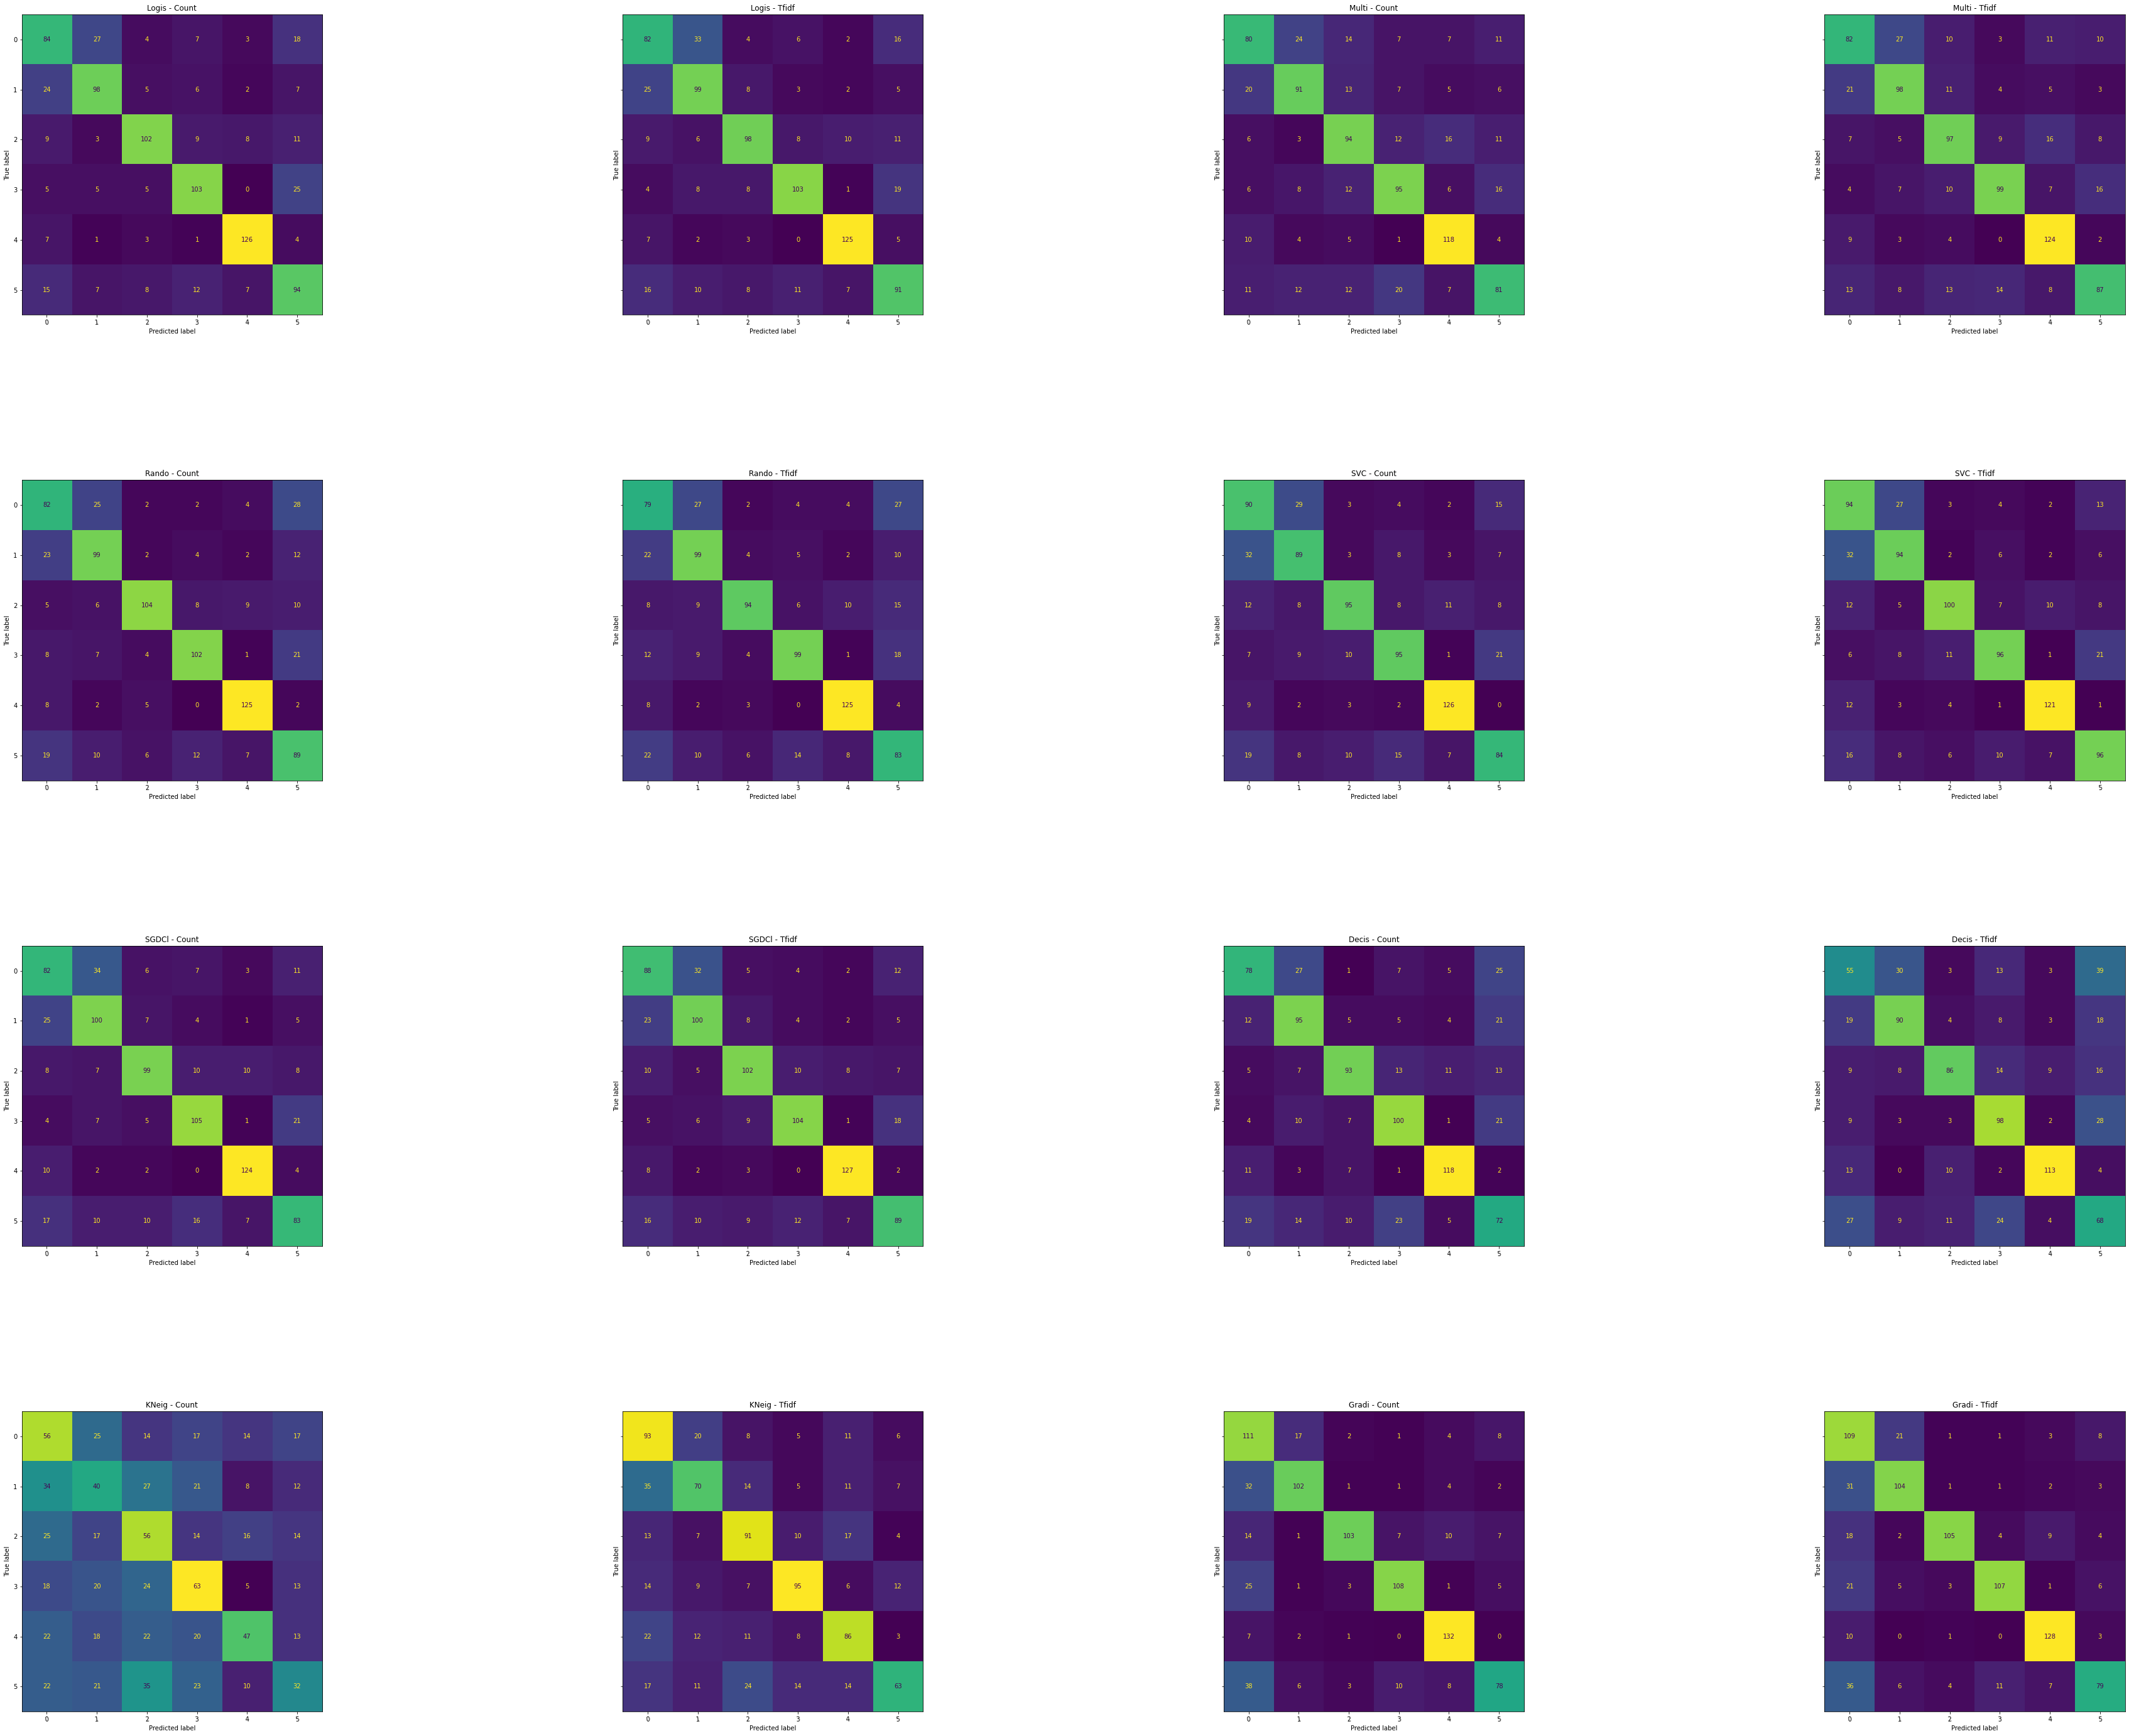

In [667]:
plot_all_confusion_matrix(modelos, vectorizers, y_test_under, y_predictions)

C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

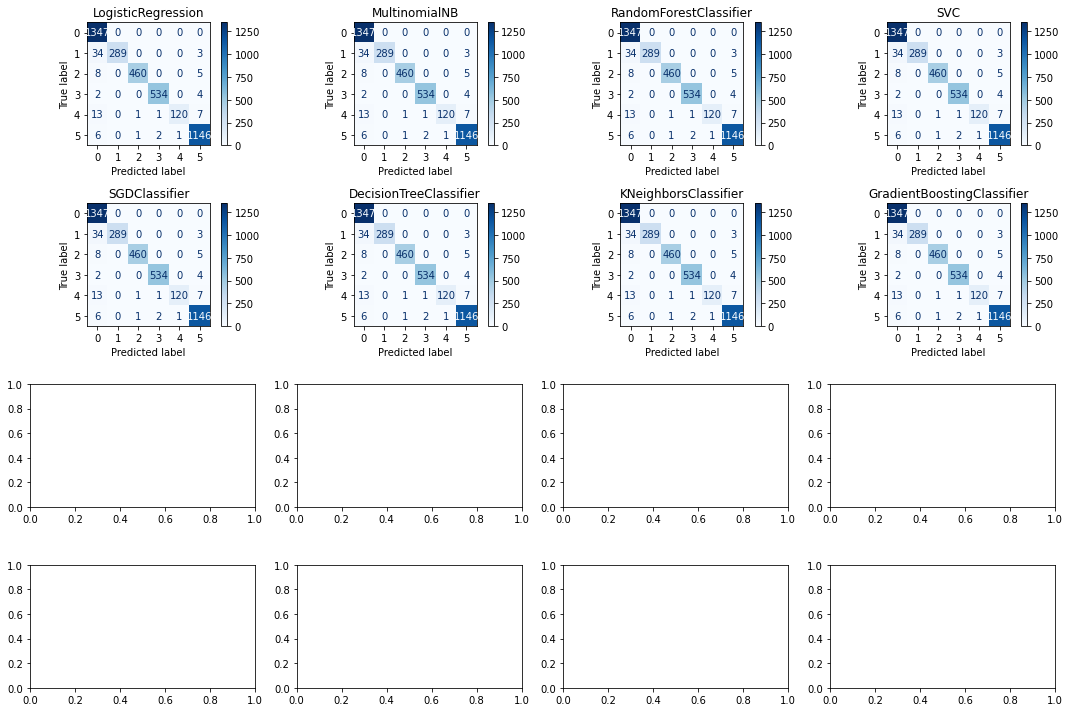

In [479]:
from sklearn.metrics import plot_confusion_matrix as ppp
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,10))

v = TfidfVectorizer()
v.fit(X_test)
X_test_data_vec = v.transform(X_test)

svc = SVC()
svc.fit(X_test_data_vec, y_test)

ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')

# # print(axes.flatten())

for cls, ax in zip(list_models, axes.flatten()):
#     ppp(cls, X_test_data_vec, y_test, ax=ax, cmap='Blues', display_labels=y_test)
    ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

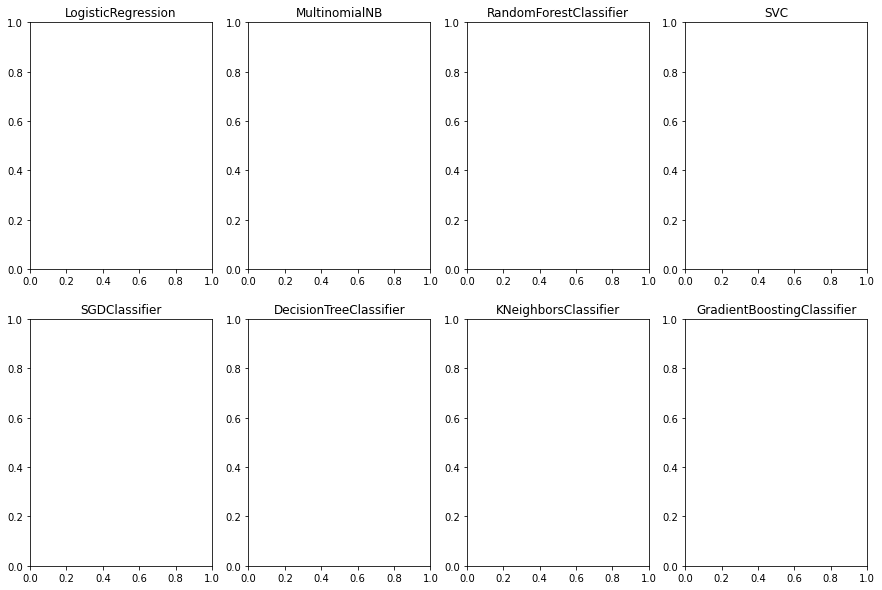

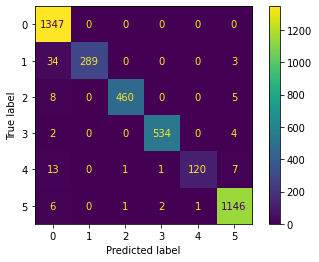

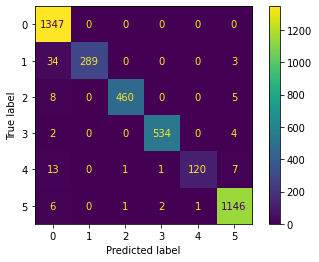

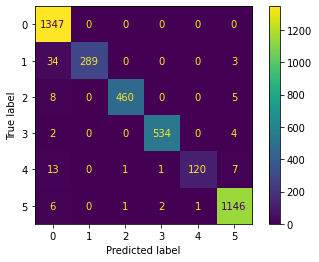

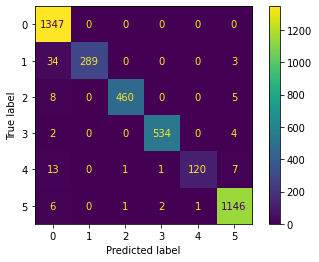

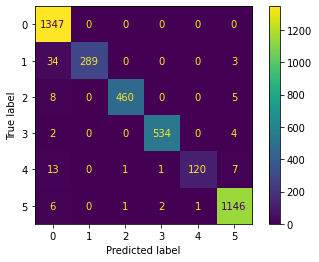

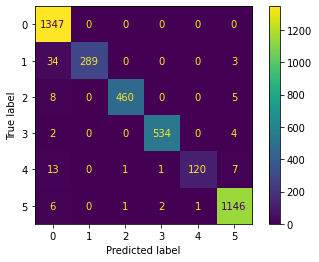

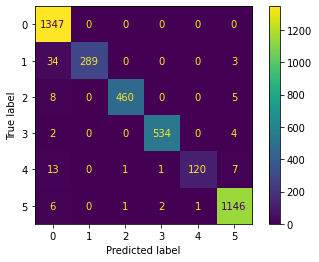

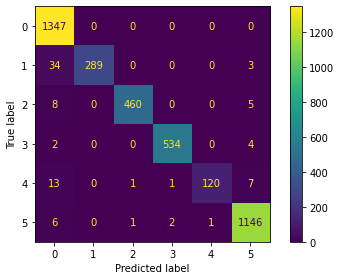

In [496]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import plot_confusion_matrix as ppp
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

v = TfidfVectorizer()
v.fit(X_test)
X_test_data_vec = v.transform(X_test)

svc = SVC()
svc.fit(X_test_data_vec, y_test)

y_pred = predict_model(svc, X_test_data_vec)

# ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')

# # print(axes.flatten())

for bb, ax in zip(list_models, axes.flatten()):
#     ppp(cls, X_test_data_vec, y_test, ax=ax, cmap='Blues', display_labels=y_test)
    cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
    disp.plot()
#     plt.show()
#     ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')
    ax.title.set_text(type(bb).__name__)
plt.tight_layout()  
# plt.show()

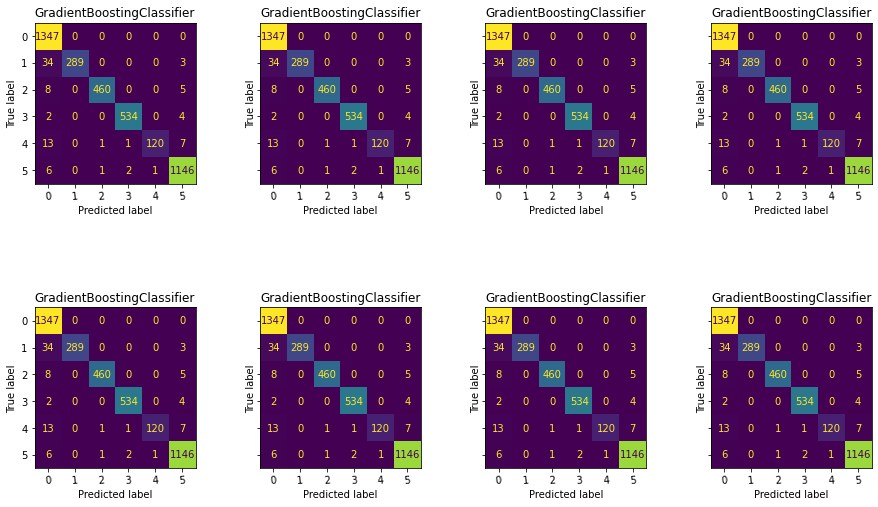

In [548]:
rows = 2
cols = 4
f, axes = plt.subplots(rows, cols, figsize=(15, 10), sharey='row')

v = TfidfVectorizer()
v.fit(X_test)
X_test_data_vec = v.transform(X_test)

svc = SVC()
svc.fit(X_test_data_vec, y_test)

y_pred = predict_model(svc, X_test_data_vec)

classifiers_aaa = {
        'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'MultinomialNB': MultinomialNB(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
        'SVC': SVC(kernel='linear'),
        'SGDClassifier': SGDClassifier(loss="log", penalty="l2"),
        'DecisionTreeClassifier': DecisionTreeClassifier(criterion="gini"),
        'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
        'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=150),
    }

cols_first_row = 0
cols_second_row = 0

# for i, (key, classifiers_aaa) in enumerate(classifiers_aaa):
for i, l in enumerate(classifiers_aaa.items()):
    cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)

    if(i > cols-1):
        disp.plot(ax=axes[1,cols_second_row], xticks_rotation=5)
        cols_second_row = cols_second_row + 1
    else:
        disp.plot(ax=axes[0,cols_first_row], xticks_rotation=5)
        cols_first_row = cols_first_row + 1
        
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
#     disp.ax_.set_xlabel('')
#     if i!=0:
#         disp.ax_.set_ylabel('')

# f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

# f.colorbar(disp.im_, ax=axes)
# f.colorbar().remove()
plt.show()

In [ ]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
# space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# space['C'] = loguniform(1e-5, 100)

# search = RandomizedSearchCV(LogisticRegression(), space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# # search = GridSearchCV(..., scoring='accuracy', n_jobs=-1)

# train_vectorized, test_vectorized = vectorize_dataframe(get_vectorize_instance('TfidfVectorizer'), X_train, X_test)

# # execute search
# result = search.fit(train_vectorized, y_train)

# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)